In [1]:
import os
from time import time
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import os
from PIL import Image
from torchvision import transforms
import random
import logging
import os
from dataclasses import dataclass
import logging
import os

In [2]:
@dataclass
class Config:
    z_dim: int = 100
    batch_size: int = 8
    num_epochs: int = 1000
    step_for_log: int = 10
    lr: float = 2e-4
    data_path: str = ""
    samples_dir: str = ""
    device: str = ""

In [3]:
if not os.path.exists("src/logs"):
    os.makedirs("src/logs")

logger = logging.getLogger("logger")
logger.setLevel(logging.INFO)
handler = logging.FileHandler(os.path.join("src/logs", "logger.txt"), encoding="utf-8")
handler.setFormatter(logging.Formatter('%(asctime)s - %(message)s'))
logger.addHandler(handler)

In [17]:
input_folder = "/kaggle/input/image-classification-64-classes-animal/image/goose"
output_folder = "/kaggle/working/data/0"

os.makedirs(output_folder, exist_ok=True)

base_transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

img_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
images = [f for f in os.listdir(input_folder) if os.path.splitext(f)[1].lower() in img_extensions]

for img_name in images:
    img_path = os.path.join(input_folder, img_name)
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Ошибка при загрузке {img_path}: {e}")
        continue
    
    crop_ratios = [0.95, 0.9, 0.85, 0.8]
    crop_transforms = [
        transforms.Compose([
            transforms.CenterCrop(size=(int(ratio*img.size[0]), int(ratio*img.size[1]))),
            transforms.Resize((128, 128)),
        ]) for ratio in crop_ratios
    ]
    
    base_img = base_transform(img)
    base_out_path = os.path.join(output_folder, f"{os.path.splitext(img_name)[0]}_orig.png")
    base_img.save(base_out_path)
    
    for i, transform in enumerate(crop_transforms):
        cropped_img = transform(img)
        out_name = f"{os.path.splitext(img_name)[0]}_crop_{i}.png"
        out_path = os.path.join(output_folder, out_name)
        cropped_img.save(out_path)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, feature_maps=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_maps * 16, 4, 1, 0, bias=False),  # 1 → 4
            nn.BatchNorm2d(feature_maps * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 16, feature_maps * 8, 4, 2, 1, bias=False),  # 4 → 8
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),  # 8 → 16
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),  # 16 → 32
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),      # 32 → 64
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),          # 64 → 128
            nn.Tanh()  # Выход: (B, img_channels, 128, 128)
        )

    def forward(self, z):
        return self.net(z)

In [23]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, stride=2, padding=1),  # 64 x 64
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_maps, feature_maps * 2, 4, stride=2, padding=1),  # 32 x 32
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, stride=2, padding=1),  # 16 x 16
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, stride=2, padding=1),  # 8 x 8
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(feature_maps * 8, 1, 8), 
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

In [29]:
class Trainer:
    def __init__(self, cfg):
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        self.generator = Generator(z_dim=cfg.z_dim).to(self.device)
        self.discriminator = Discriminator().to(self.device)

        self.gen_opt = optim.Adam(self.generator.parameters(), lr=cfg.lr, betas=(0.5, 0.999))
        self.disc_opt = optim.Adam(self.discriminator.parameters(), lr=cfg.lr, betas=(0.5, 0.999))

        self.bce = nn.BCELoss()

        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3)
        ])

        dataset = datasets.ImageFolder(cfg.data_path, transform=transform)
        self.dataloader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)

        os.makedirs(cfg.samples_dir, exist_ok=True)

    def train(self):
        self.global_time = time()
        logger.info(f"Training started on device: {self.device}")

        for epoch in range(self.cfg.num_epochs):
            epoch_start = time()
            disc_time_total = 0
            gen_time_total = 0

            for real_imgs, _ in self.dataloader:
                real_imgs = real_imgs.to(self.device)
                batch_size = real_imgs.size(0)

                disc_start = time()

                noise = torch.randn(batch_size, self.cfg.z_dim, 1, 1, device=self.device)
                fake_imgs = self.generator(noise)

                real_labels = torch.ones(batch_size, 1, device=self.device)
                fake_labels = torch.zeros(batch_size, 1, device=self.device)

                real_preds = self.discriminator(real_imgs)
                fake_preds = self.discriminator(fake_imgs.detach())

                real_preds = real_preds.view(batch_size, 1)
                fake_preds = fake_preds.view(batch_size, 1)

                d_loss_real = self.bce(real_preds, real_labels)
                d_loss_fake = self.bce(fake_preds, fake_labels)
                d_loss = d_loss_real + d_loss_fake

                self.disc_opt.zero_grad()
                d_loss.backward()
                self.disc_opt.step()

                disc_end = time()
                disc_time_total += (disc_end - disc_start)

                gen_start = time()

                noise = torch.randn(batch_size, self.cfg.z_dim, 1, 1, device=self.device)
                fake_imgs = self.generator(noise)
                preds = self.discriminator(fake_imgs).view(batch_size, 1)
                g_loss = self.bce(preds, real_labels)

                self.gen_opt.zero_grad()
                g_loss.backward()
                self.gen_opt.step()

                gen_end = time()
                gen_time_total += (gen_end - gen_start)
            if epoch % self.cfg.step_for_log == 0 and epoch != 0:
                epoch_end = time()
                epoch_time = epoch_end - epoch_start
                print(f"Epoch [{epoch}/{self.cfg.num_epochs}] | "
                    f"D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f} | "
                    f"Epoch_time: {epoch_time:.3f}s ")
                logger.info(
                    f"Epoch [{epoch}/{self.cfg.num_epochs}] | "
                    f"D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f} | "
                    f"Epoch_time: {epoch_time:.3f}s | "
                    f"Disc_train_time: {disc_time_total:.3f}s | "
                    f"Gen_train_time: {gen_time_total:.3f}s"
                )
                self.save_samples(epoch)

        total_training_time = time() - self.global_time
        logger.info(f"Training finished. Total time: {total_training_time:.3f}s")

    def save_samples(self, epoch):
        start_save = time()

        with torch.no_grad():
            noise = torch.randn(25, self.cfg.z_dim, 1, 1, device=self.device)
            fake_imgs = self.generator(noise)
            fake_imgs = (fake_imgs + 1) / 2
            utils.save_image(fake_imgs, os.path.join(self.cfg.samples_dir, f"epoch_{epoch:03d}.png"), nrow=5)

        end_save = time()
        save_time = end_save - start_save
        logger.info(f"Saved samples for epoch {epoch} in {save_time:.3f}s")

In [30]:
cfg = Config()
cfg.device = "cuda" if torch.cuda.is_available() else "cpu"
cfg.batch_size = 128
cfg.data_path = "/kaggle/working/data"
cfg.num_epochs = 301
cfg.step_for_log = 10
cfg.samples_dir = "/kaggle/working/progress"
logger.info(f"Using device: {cfg.device}")
trainer = Trainer(cfg)
trainer.train()

Epoch [10/301] | D_loss: 0.2690 G_loss: 3.0011 | Epoch_time: 3.062s 
Epoch [20/301] | D_loss: 0.3221 G_loss: 3.8777 | Epoch_time: 3.067s 
Epoch [30/301] | D_loss: 2.0790 G_loss: 7.0468 | Epoch_time: 3.039s 
Epoch [40/301] | D_loss: 0.8596 G_loss: 6.6560 | Epoch_time: 3.060s 
Epoch [50/301] | D_loss: 0.4214 G_loss: 3.1680 | Epoch_time: 3.074s 
Epoch [60/301] | D_loss: 0.8479 G_loss: 8.6004 | Epoch_time: 3.060s 
Epoch [70/301] | D_loss: 2.5127 G_loss: 4.0515 | Epoch_time: 3.055s 
Epoch [80/301] | D_loss: 0.4667 G_loss: 4.6560 | Epoch_time: 3.068s 
Epoch [90/301] | D_loss: 0.1962 G_loss: 3.2563 | Epoch_time: 3.057s 
Epoch [100/301] | D_loss: 0.3635 G_loss: 5.1087 | Epoch_time: 3.036s 
Epoch [110/301] | D_loss: 0.2337 G_loss: 3.8014 | Epoch_time: 3.055s 
Epoch [120/301] | D_loss: 0.4978 G_loss: 6.6399 | Epoch_time: 3.054s 
Epoch [130/301] | D_loss: 0.4391 G_loss: 6.0429 | Epoch_time: 3.050s 
Epoch [140/301] | D_loss: 0.5148 G_loss: 6.2667 | Epoch_time: 3.062s 
Epoch [150/301] | D_loss: 0.0

In [44]:
import matplotlib.pyplot as plt
from PIL import Image
def draw_img(img_path):
    img = Image.open(img_path)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

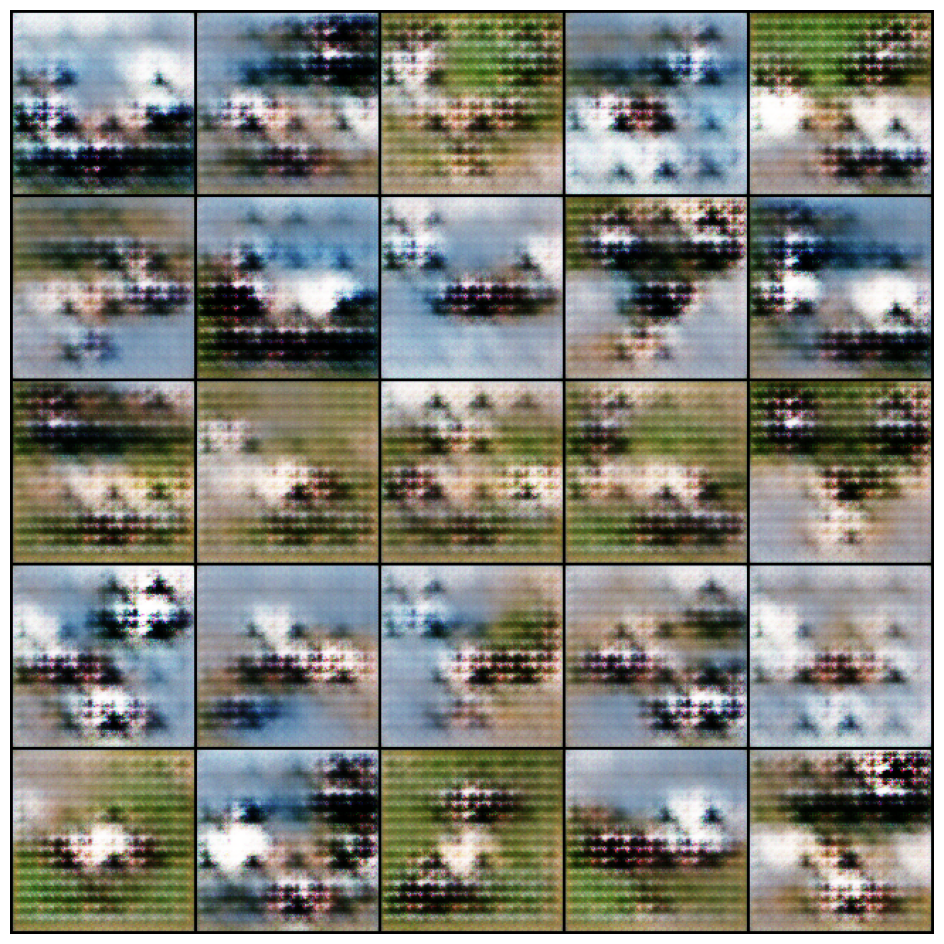

In [45]:
draw_img("/kaggle/working/progress/epoch_050.png")

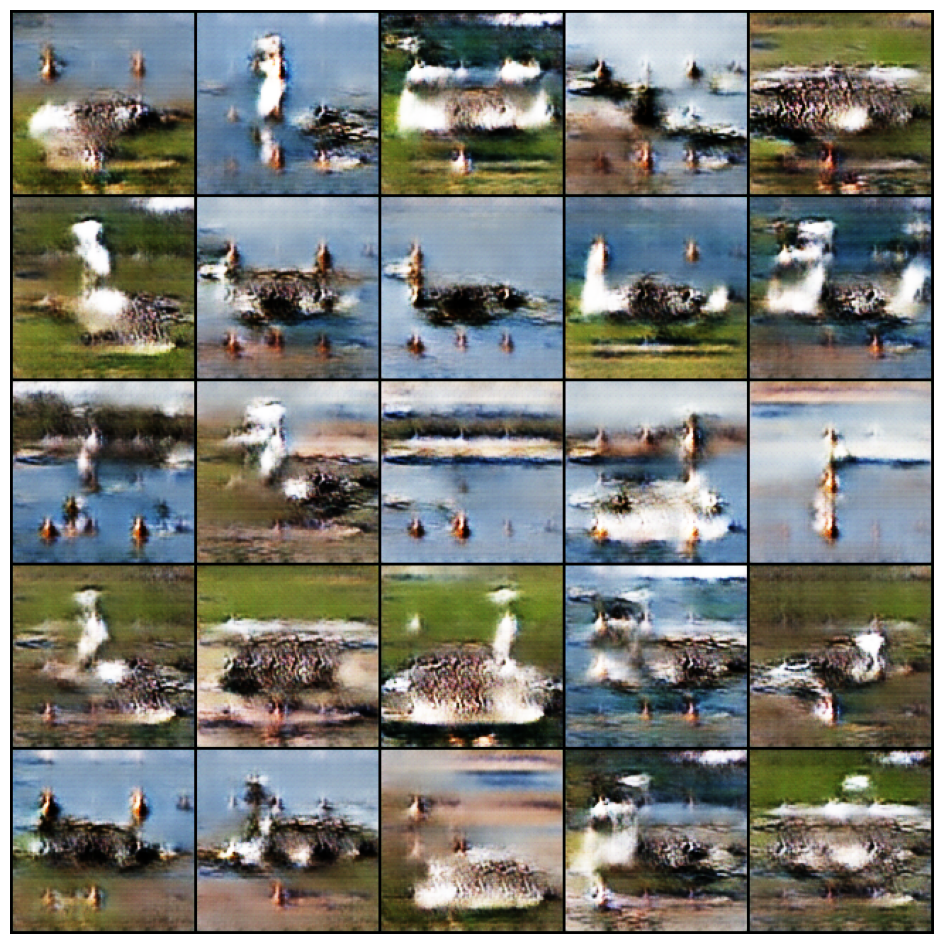

In [46]:
draw_img("/kaggle/working/progress/epoch_240.png")

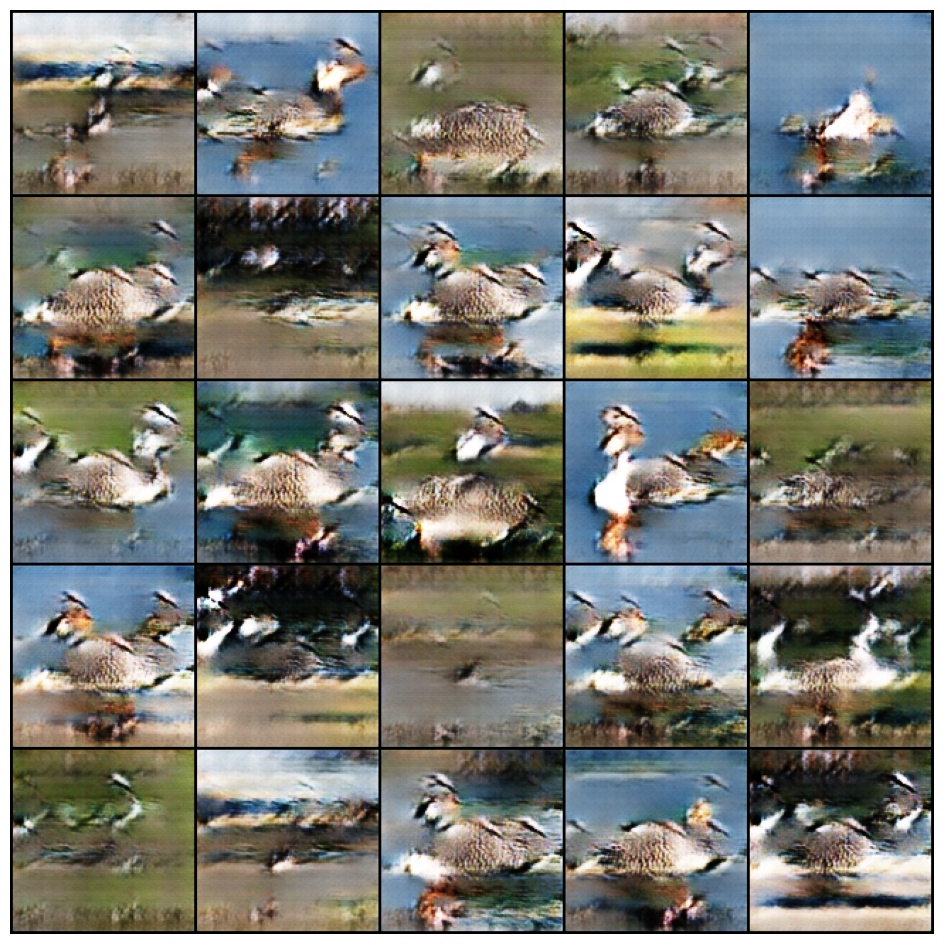

In [47]:
draw_img("/kaggle/working/progress/epoch_300.png")